## Extracting Metrics
Marking areas of interest and matching them with fixations helps us get a first visual impression of the data. But if we want to compare areas of interest with each other we need to quantify some metrics. 

We will show you here how to compute 3 common metrics: 
- AOI Hit Rate
- Time to first Fixation
- Dwell Time

This notbook uses the fle "fixations_with_aois_nested.csv" or "fixations_with_aois_distributed.csv" that can be generated with the code in the notebook "Defining nested AOIs" or "Defining distributed AOIs". 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from PIL import Image

# define if you are working with nested or distributed AOIs
aoi_layout = 'nested'

# set the path on you pc, and define a color map
if aoi_layout == 'distributed':
    palette = 'viridis'
    path_to_reference_image_mapper = './reference_image_enrichments/'
elif aoi_layout == 'nested':
    palette = 'plasma'
    path_to_reference_image_mapper = "./Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_multiple_paintings_standing_csv"
else:
    raise NotImplementedError("Please use the aoi_layout 'nested' or 'distributed'.")
    
# import fixation data
fixations = pd.read_csv(f'fixations_with_aois_{aoi_layout}.csv')

# larger labels are nicer to read
plt.rcParams.update({'font.size': 18})

### AOI Hit Rate

The Hit Rate of an AOI is defined as the proportion of subjects that looked at the AOI at least once. 
A Hit Rate of 100% means, every person we recorded looked at the AOI, a Hit Rate of 50% indicates that only every second person looked at the AOI, etc.

In [2]:
# first, we extract the hit count
fixation_counts = fixations.pivot_table(index = 'section id', 
                      columns = 'AOI',
                      values = 'fixation id',
                      fill_value = 0, 
                      aggfunc = 'count').unstack().to_frame().rename(columns = {0:'fixation count'})
fixation_counts.reset_index(inplace = True)

# and boil it down to yes/no
hits = fixation_counts.copy()
hits['hit'] = hits['fixation count']>0

# make sure the AOI field is an interger
hits['AOI'] = hits['AOI'].astype(int)

The result is a table that tells us for every AOI and recording id, how often a fixation was detected inside the AOI for that recording (fixation count), and if there was at least one fixation detected (hit).

### Visualizing aggregated data
To visualize the data, we use the library seaborn. Seaborn is a library for statistical data visualization that allows us to aggregate and plot the data in a few lines of code.

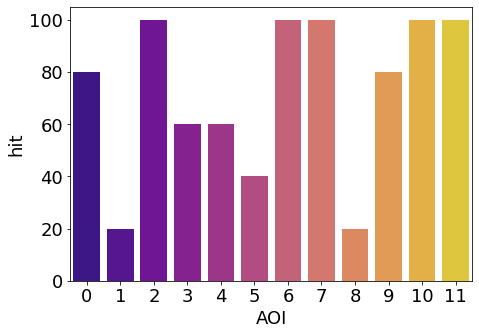

In [3]:
import seaborn as sns

hit_rate_fig, hit_rate_axs = plt.subplots(1,1, figsize = (7,5))

# Get the mean hit rate over observers and plot
proportional_hits = hits.groupby('AOI').mean().reset_index()
proportional_hits.loc[:,'hit'] =  proportional_hits['hit']*100

sns.barplot(x="AOI", y="hit", data=proportional_hits, palette = palette, ax = hit_rate_axs)
plt.tight_layout()
hit_rate_fig.savefig(f'./figures/hit_rate_{aoi_layout}.png');

From this figure, we can see what percentage of observers looked at each AOI.

### Time to first contact
Time to first contact measures how long it took observers to look at an AOI for the first time. Short times to first contact mean that the observers looked at the AOI early during the section.

We can compute time to first fixation as the difference between the time when the first fixation was registered on an AOI anf the time when the section started.

### Import section data

In [4]:
if aoi_layout == 'nested':
    sections = pd.read_csv(f"{path_to_reference_image_mapper}/sections.csv")
elif aoi_layout == 'distributed':
    sections = pd.DataFrame()
    for directory in os.listdir(path_to_reference_image_mapper):
        one_section = pd.read_csv(f"{path_to_reference_image_mapper}/{directory}/sections.csv")
        sections = pd.concat([sections, one_section]).drop_duplicates().reset_index(drop=True)
    
sections.head()

,section id,recording id,recording name,wearer id,wearer name,section start time [ns],section end time [ns],start event name,end event name
0,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,SH_D_S,f5ac063b-fe37-41da-9361-22e0184f0446,SH,1636035560120000000,1636035572525000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
1,12050eb8-2135-4820-8a89-472863ef60f2,9583339a-cc7c-41ad-a242-b0db2e421866,JR_D_S,9508d4f6-e26f-48e1-b53f-051d47d27c91,JR,1635864181664000000,1635864196355000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
2,2ad6cf23-bbfb-47c4-b9cd-b9612c3327e4,b1eaf63d-a388-4c85-86a4-fa855bc4bea3,AM_D_S,ccd39285-42ae-4780-b119-042974777e7f,AM,1636382551779000000,1636382577933000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
3,57840658-7bab-4812-ad96-5f8197f2c195,c9431f2d-9299-4234-81b7-1df1e3e6e97c,SN_D_S,fb6c7332-6a81-4449-825f-57c2d77fba86,SN,1636386863776000000,1636386886095000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end
4,8bf462f6-7dca-406c-80a5-0fd7604ff5e6,737e94b0-89e5-4d1b-9b06-57d84e51eaca,MT_D_S,d7c42b07-2256-4af9-96a1-22704d8b7f68,MT,1636634036249000000,1636634060648000000,multiple_paintings_10sec_start,multiple_paintings_10sec_end


### Align timestamps to section start

In [5]:
fixations['aligned timestamp [s]'] = None

for section in sections['section id']:
    section_idx = fixations[fixations['section id'] == section].index
    section_start_time = sections.loc[sections['section id'] == section, 'section start time [ns]'].values
    fixations.loc[section_idx, 'aligned timestamp [s]'] = (fixations.loc[section_idx, 'start timestamp [ns]'] - section_start_time)/1e9 

### Aggregate and extract first fixation time

In [6]:
first_contact = pd.DataFrame(fixations.groupby(['section id', 'AOI']).min()['aligned timestamp [s]'])
first_contact.reset_index(inplace = True)
# make sure the AOI field is an interger
first_contact['AOI'] = first_contact['AOI'].astype(int)

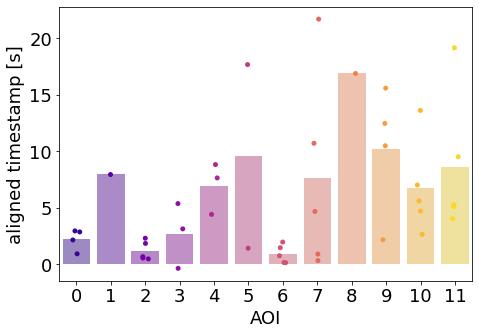

In [7]:
first_contact_fig, first_contact_ax = plt.subplots(1,1, figsize=(7,5))
sns.barplot(x="AOI", y="aligned timestamp [s]", 
            data=first_contact, palette = palette, ci = None,
            ax = first_contact_ax, alpha = 0.5)

sns.stripplot(x="AOI", y="aligned timestamp [s]", 
            data=first_contact, palette = palette, 
            ax = first_contact_ax);

plt.tight_layout()
first_contact_fig.savefig(f'./figures/first_contact_{aoi_layout}.png');

We can observe that some AOIs were looked at after short time, while other where only explored later. 

This plot shows individual data points together with a barplot of the mean values. We can leverage the individual data points to get an estimate of the distribution, outliers, and how many data points contributed to the mean.

### Dwell time

Dwell time describes the total time an observer has looked at a given AOI. We can find the dwell time by summing up the durations of all fixations we detected, seperately for each AOI.

In [8]:
# add recording name for better readablity
dwell = fixations.groupby(['section id', 'AOI']).sum()['duration [ms]']
dwell = pd.DataFrame(dwell).sort_values('AOI')
dwell.reset_index(inplace = True)
# make sure the AOI field is an interger
dwell['AOI'] = dwell['AOI'].astype(int)

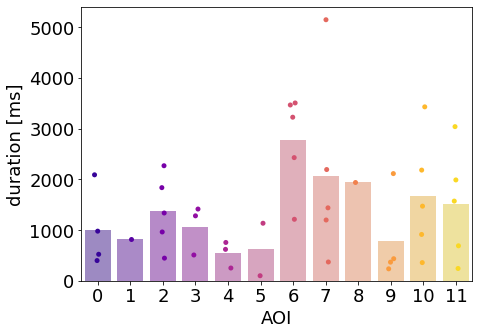

In [9]:
# plot the average time spent on each image
dwell_time_fig, dwell_time_ax = plt.subplots(1,1, figsize=(7,5))

sns.barplot(x = "AOI", y = "duration [ms]",
            data = dwell, palette = palette, 
            ci = None, ax = dwell_time_ax, alpha = 0.5)

sns.stripplot(x="AOI", y="duration [ms]", 
            data=dwell, palette = palette, 
            ax = dwell_time_ax);

plt.tight_layout()
dwell_time_fig.savefig(f'./figures/dwell_time_{aoi_layout}.png');

Oftentimes, the dwell time is longest at the locations that were looked at first, and by most people. 